# Caption Generation using GRU architecture

In [1]:
import os
import string
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Dropout, Add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Activation, Flatten, Bidirectional
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from nltk.translate.bleu_score import corpus_bleu
import pickle

import matplotlib.pyplot as plt

from tensorflow.keras.layers import BatchNormalization, RepeatVector, Dot, Activation,Concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_DIR = '/home/panchani.d/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/'

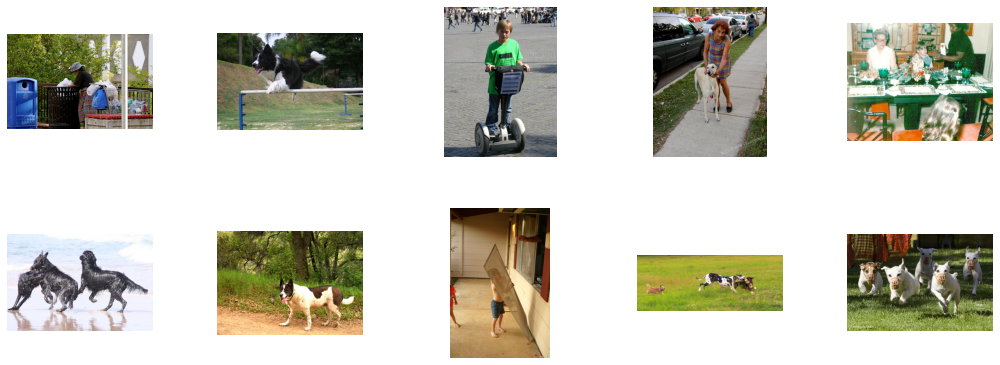

In [3]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')  
image_filenames = os.listdir(IMAGES_DIR)

# Select 12 random images for display 
image_name_idx = np.random.randint(0,8000,10)

images = [image_filenames[i] for i in image_name_idx]
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) #12 image in 2 rows and 6 columns
fig.tight_layout(pad=3.0)

# Display images without captions
for i, ax in enumerate(axes.flat):
    img_path = os.path.join(IMAGES_DIR, images[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes and captions 
plt.show()

In [4]:
def extract_features(directory):
    # """Extract features from each image in the directory using InceptionV3"""
    model = InceptionV3(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print("Extracting Features")
    features = {}
    for name in tqdm(os.listdir(directory)):
        filename = directory + '/' + name
        if filename.endswith('.jpg'):
            image = load_img(filename, target_size=(299, 299))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            image_id = name.split('.')[0]
            features[image_id] = feature
    return features

In [24]:
# Extract image features
directory = BASE_DIR + 'Images'
features = extract_features(directory)
# save_file("data/image_features.pkl")
# with open('image_features.pkl', 'rb') as f:
#     features = pickle.load(f)
# print('Extracted Features:', len(features))

  0%|          | 0/8091 [00:00<?, ?it/s]

Extracting Features


100%|██████████| 8091/8091 [16:05<00:00,  8.38it/s]


In [25]:
features

{'1000268201_693b08cb0e': array([[0.12277611, 0.33294964, 0.75271714, ..., 0.21939678, 0.30216396,
         0.4028313 ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.7366838 , 0.5911328 , 0.18194196, ..., 0.16030277, 0.34144685,
         0.9083164 ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[0.37351882, 0.24596655, 0.96352994, ..., 1.1459366 , 0.26540172,
         0.01983146]], dtype=float32),
 '1003163366_44323f5815': array([[0.4860316 , 0.29218328, 0.31436828, ..., 0.9825469 , 0.2810809 ,
         0.22330073]], dtype=float32),
 '1007129816_e794419615': array([[0.21595362, 0.15582031, 0.29477048, ..., 0.4056499 , 0.16532096,
         0.37416834]], dtype=float32),
 '1007320043_627395c3d8': array([[0.1723103 , 0.49808323, 0.21576959, ..., 0.09676263, 1.2298476 ,
         0.5421406 ]], dtype=float32),
 '1009434119_febe49276a': array([[0.53460884, 1.3676219 , 0.78043604, ..., 0.39463824, 0.88772273,
         1.0728817 ]], dtype=float32),
 '1012212859_01547e3f17': array([[

In [26]:
# with open('train_features-Final.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [5]:
with open('train_features-Final.pkl', 'rb') as f:
    features = pickle.load(f)  

print('Extracted Features:', len(features))

Extracted Features: 8091


In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    # to skip the first row on the captions file 
    next(f)
    # read all captions file
    captions_doc = f.read()

In [7]:
# create mapping of image to captions
descriptions = {}

for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if image ID will added to the first time
    if image_id not in descriptions:
        descriptions[image_id] = []
    # store the caption if the image ID already exting in the mapping dict
    descriptions[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 751412.68it/s]


## Display Images with Captions

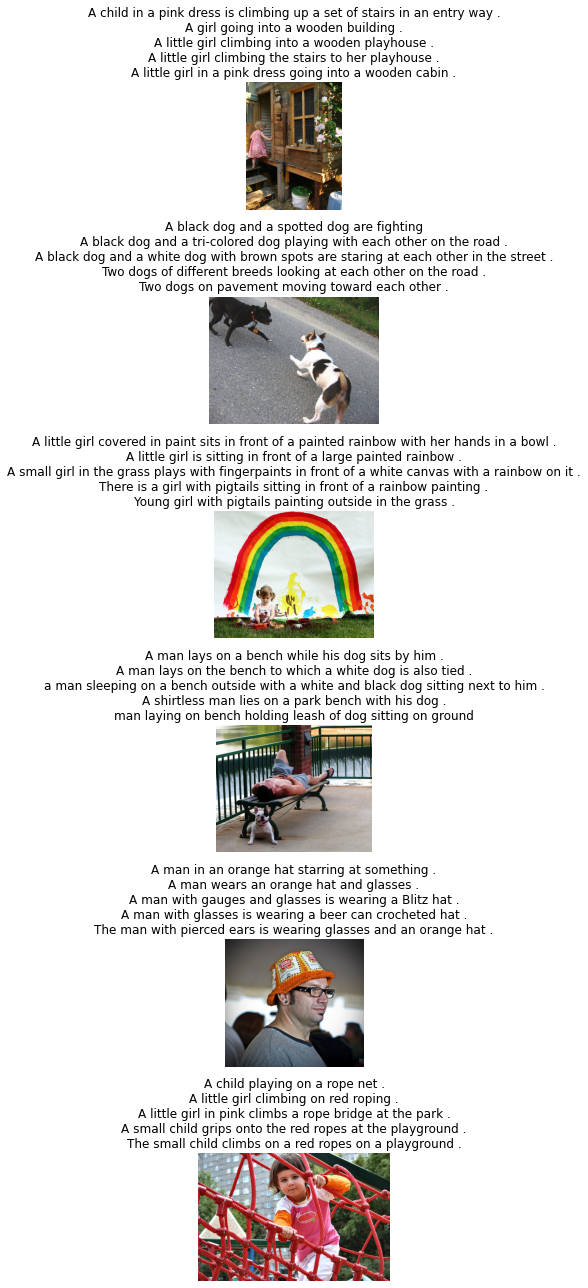

In [8]:
# after preparing the captions , we will display a sample of the data with captions
def display_images_with_captions(directory, descriptions, num_images=6):
    # Get all image filenames from the directory
    img_names = os.listdir(directory)[:num_images]  # to get 6 images ..note if you want to display more handle the num of images 
    # Create a figure with 6 rows (one for each image) and 1 column
    fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 3))

    for i, img_name in enumerate(img_names):
        # Extract image ID by removing file extension
        image_id = img_name.split('.')[0]
        # Ensure the image ID is in the mapping dictionary
        if image_id in descriptions:
            # Load the image
            img_path = os.path.join(directory, img_name)
            img = plt.imread(img_path)
        # Plot the image in the corresponding row
            axes[i].imshow(img)
            axes[i].axis('off') 
            # Get the corresponding captions from the mapping
            captions = descriptions[image_id][:5]  # Get the first 5 captions
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Directory containing images
image_directory = os.path.join(BASE_DIR, 'Images')
# Call the function to display images with captions
display_images_with_captions(image_directory, descriptions)

In [9]:
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption ---> important in text generation
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
clean_captions(descriptions)

In [11]:
all_captions = []
for key in descriptions:
    for caption in descriptions[key]:
        all_captions.append(caption)

len(all_captions)

40455

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [13]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [14]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Data Preparation

In [15]:
def data_generator(data_keys, descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key in data_keys:
            n += 1
            captions = descriptions[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = [], [], []
                n = 0

# Model Creation

In [16]:
# GRU Model Architecture with Optimizations
inputs1 = Input(shape=(2048,), name='image')
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(128, activation='relu')(fe1)  # Reduced to 128 units
fe2_projected = RepeatVector(max_length)(fe2)

# Text input
inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)  # Reduced to 128
se2 = BatchNormalization()(se1)
se3 = Bidirectional(GRU(128, return_sequences=True))(se2)    
# GRU(128, return_sequences=True)(se2)  # Reduced to 128

# Simplified Attention Mechanism
attention = Dense(1, activation="tanh")(se3)
attention = Activation('softmax')(attention)
context_vector = Dot(axes=1)([attention, se3])
context_vector = BatchNormalization()(context_vector)

# Decoder
context_vector = Flatten()(context_vector)
decoder1 = Concatenate()([context_vector, fe2])
decoder2 = Dense(256, activation='relu')(decoder1)  # Reduced to 256
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 35)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 128)              1086080   ['text[0][0]']                
                                                                                                  
 batch_normalization_1 (Bat  (None, 35, 128)              512       ['embedding[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 bidirectional (Bidirection  (None, 35, 256)              198144    ['batch_normalization_1[0]

In [25]:
epochs = 40
batch_size = 32

# prepare a list of image IDs
image_ids = list(descriptions.keys())

steps = len(image_ids) // batch_size
for i in range(epochs):
    generator = data_generator(image_ids, descriptions, features, tokenizer, max_length, vocab_size, batch_size)
    history= model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 [==============================] - 175s 695ms/step - loss: 0.8043 - accuracy: 0.7650


In [26]:
model.save('GRU_Model.keras')

# Load the trained Model

In [16]:
import keras
model = keras.models.load_model('GRU_Model.keras')

# Generate Captions
Here, we use the trained model to generate captions for new images. This involves feeding image features into the model and decoding predicted sequences into human-readable text.

In [17]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [18]:
# generate caption for an image

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post')
        # predict next word in the sentence
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability of the next word
        yhat = np.argmax(yhat)
        # convert index to word (look at the function above)
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [19]:
def generate_caption(image_name):
    # Extract image ID
    image_id = image_name.split('.')[0]

    # Load the image file
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Generate the predicted caption
    prediction = predict_caption(model, features[image_id], tokenizer, max_length)

    # Remove the 'startseq' and 'endseq' tags from the caption for display and audio
    caption_text = prediction.replace('startseq', '').replace('endseq', '').strip()

    # Display the predicted caption
    print("Predicted Caption:", caption_text)

    # # Step 1: Generate the audio for the caption using gTTS
    # tts = gTTS(caption_text, lang='en')
    # audio_path = "predicted_caption.mp3"
    # tts.save(audio_path)

    # # Step 2: Display the audio player before the image
    # print("Playing the predicted caption audio:")
    # display(Audio(audio_path, autoplay=True))

    # Step 3: Display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

Predicted Caption: two children dangling from each other as spectators watch


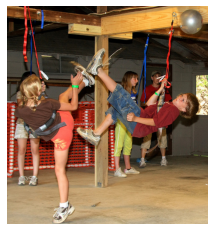

Predicted Caption: little boy wearing white jumps his arms in the air while two adult watch


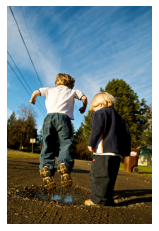

Predicted Caption: blurred vision of bike top up hill


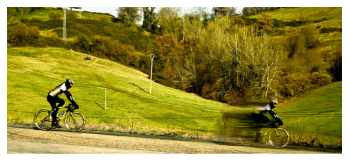

In [20]:
# choose random 3 images to get the captions of them

images_path = os.listdir(os.path.join(BASE_DIR,'Images'))
image_name_idx = np.random.randint(0,8000,3)

for i in image_name_idx:
    generate_caption(images_path[i])

# Evaluate Model
In this section, we evaluate the performance of the trained model using metrics such as accuracy or BLEU scores. We may also visualize some generated captions to qualitatively assess model performance.

In [21]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# ================== Evaluate the Model ==================
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    
    # Loop over each image description
    for key, desc_list in tqdm(descriptions.items()):
        # Generate a caption using the model
        yhat = generate_caption(model, photos[key], tokenizer, max_length)
        
        # Prepare references for BLEU score calculation
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    
    # # Calculate BLEU scores
    # print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    # print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    # Calculate and print BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    print(f'BLEU-1: {bleu1:.4f}')
    print(f'BLEU-2: {bleu2:.4f}')
    print(f'BLEU-3: {bleu3:.4f}')
    print(f'BLEU-4: {bleu4:.4f}')

# ================== Caption Generation ==================
def generate_caption(model, photo, tokenizer, max_length):
    in_text = 'startseq'
    
    # Generate word by word until reaching max_length or end token
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word in sequence
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Convert integer to word
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        
        # Stop if end of sequence is predicted
        if word == 'endseq':
            break
    
    return in_text.replace('startseq', '').replace('endseq', '').strip()

In [32]:
import random

def select_random_keys(original_dict, num_keys=1000):
    # Ensure the requested number of keys does not exceed the number of keys in the original dictionary
    num_keys = min(num_keys, len(original_dict))
    
    # Randomly sample keys from the original dictionary
    selected_keys = random.sample(list(original_dict.keys()), num_keys)
    
    # Create a new dictionary with only the selected keys
    new_dict = {key: original_dict[key] for key in selected_keys}
    
    return new_dict

test_descriptions = select_random_keys(descriptions, 1000)

In [33]:
# Evaluate the model
evaluate_model(model, test_descriptions, features, tokenizer, max_length)

100%|██████████| 1000/1000 [06:37<00:00,  2.52it/s]


BLEU-1: 0.5767
BLEU-2: 0.4391
BLEU-3: 0.3426
BLEU-4: 0.2697


## Semantic distance between the actual and the predicted titles for GRU architecture.

In [22]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")  # Pre-trained GloVe vectors

In [23]:
def get_caption_vector(caption, model, embedding_dim=300):
    words = caption.split()
    vector = np.zeros((embedding_dim,))
    valid_words = 0
    for word in words:
        if word in model:
            vector += model[word]
            valid_words += 1
    if valid_words > 0:
        vector /= valid_words
    return vector

def calculate_semantic_distance(actual_caption, predicted_caption, model, embedding_dim=300):
    actual_vector = get_caption_vector(actual_caption, model, embedding_dim)
    predicted_vector = get_caption_vector(predicted_caption, model, embedding_dim)
    similarity = cosine_similarity([actual_vector], [predicted_vector])[0][0]
    semantic_distance = 1 - similarity
    return semantic_distance

In [24]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    total_semantic_distance = 0

    # Loop over each image description
    for key, desc_list in tqdm(descriptions.items()):
        # Generate a caption using the model
        predicted_caption = generate_caption(model, photos[key], tokenizer, max_length)

        # Prepare references for BLEU score calculation
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(predicted_caption.split())

        # Calculate semantic distance for each predicted and actual caption pair
        avg_semantic_distance = np.mean([
            calculate_semantic_distance(" ".join(ref), predicted_caption, glove_model) for ref in references
        ])

        total_semantic_distance += avg_semantic_distance

    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    # Print BLEU scores
    print(f'BLEU-1: {bleu1:.4f}')
    print(f'BLEU-2: {bleu2:.4f}')
    print(f'BLEU-3: {bleu3:.4f}')
    print(f'BLEU-4: {bleu4:.4f}')

    # Calculate average semantic distance
    avg_semantic_distance = total_semantic_distance / len(descriptions)
    print(f'Average Semantic Distance: {avg_semantic_distance:.4f}')

In [25]:
import random

def select_random_keys(original_dict, num_keys=1000):
    # Ensure the requested number of keys does not exceed the number of keys in the original dictionary
    num_keys = min(num_keys, len(original_dict))
    
    # Randomly sample keys from the original dictionary
    selected_keys = random.sample(list(original_dict.keys()), num_keys)
    
    # Create a new dictionary with only the selected keys
    new_dict = {key: original_dict[key] for key in selected_keys}
    
    return new_dict

test_descriptions = select_random_keys(descriptions, 1000)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# Evaluate the model
evaluate_model(model, test_descriptions, features, tokenizer, max_length)

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


BLEU-1: 0.5786
BLEU-2: 0.4445
BLEU-3: 0.3546
BLEU-4: 0.2825
Average Semantic Distance: 0.2054
